# Convex Minimization Example
This notebook demonstrates how to solve the convex minimization problem in the proposed algorithm.

In [1]:
import numpy as np
import cvxpy as cp

In [2]:
# Setup
ACT_DIM = 2  # action space dimensions
ETA = 1e-8  # used to enforce strict inequality

alpha = cp.Parameter()  # (> 1) constraint on maximum policy ratio

# safe policy (cvxpy parameters)
mu_safe = cp.Parameter(ACT_DIM)
sigma_safe = cp.Parameter(ACT_DIM, pos=True)

# task policy (cvxpy parameters)
mu_task = cp.Parameter(ACT_DIM)
sigma_task = cp.Parameter(ACT_DIM, pos=True)

# projected policy (cvxpy variables)
mu_proj = cp.Variable(ACT_DIM)
sigma_proj = cp.Variable(ACT_DIM, pos=True)

In [3]:
# Problem definition
objective_dcp = cp.Minimize(
    -2 * cp.sum(cp.log(sigma_proj))
    + cp.sum_squares(sigma_proj / sigma_task)
    + cp.sum_squares((mu_proj - mu_task) / sigma_task)
)

constraints_dcp = []

constraint_1_dcp = sigma_proj + ETA <= sigma_safe
constraints_dcp.append(constraint_1_dcp)

sum_term_dcp = 0  # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dcp += cp.quad_over_lin(
        mu_proj[i] - mu_safe[i], cp.square(sigma_safe[i]) - cp.square(sigma_proj[i])
    )  # note that numerator gets squared (which we want)

constraint_2_dcp = cp.sum(cp.log(sigma_safe)) - cp.sum(cp.log(sigma_proj)) + (
    1 / 2
) * sum_term_dcp <= cp.log(alpha)
constraints_dcp.append(constraint_2_dcp)

prob_dcp = cp.Problem(objective_dcp, constraints_dcp)

# Check problem is DCP
CHECK_DPP = False
print(objective_dcp.is_dcp(dpp=CHECK_DPP))
print(constraint_1_dcp.is_dcp(dpp=CHECK_DPP))
print(constraint_2_dcp.is_dcp(dpp=CHECK_DPP))
print(prob_dcp.is_dcp(dpp=CHECK_DPP))

True
True
True
True


In [50]:
# Generate examples
alpha.value = 1.1  # (> 1) constraint on maximum policy ratio

STRAY_FACTOR = 0.05  # factor on how far the task policy strays from the safe policy

# safe policy
mu_safe.value = np.random.randn(ACT_DIM)
sigma_safe.value = np.random.exponential(size=ACT_DIM)  # > 0

# task policy
mu_task.value = mu_safe.value + STRAY_FACTOR * np.random.randn(
    ACT_DIM
)  # put task policy mean somewhere fairly close to safe policy mean
sigma_task.value = sigma_safe.value - np.minimum(
    STRAY_FACTOR * sigma_safe.value * np.random.exponential(size=ACT_DIM),
    sigma_safe.value - ETA,
)  # put task policy stdev somewhere fairly close to but less than safe policy stdev (and > 0)

In [51]:
# Solve problem
result = prob_dcp.solve()
print(mu_safe.value, sigma_safe.value)
print(mu_task.value, sigma_task.value)
print(mu_proj.value, sigma_proj.value)

[-0.66178255  0.49119267] [0.49148991 0.25500897]
[-0.68317929  0.45952224] [0.47222406 0.23724024]
[-0.66695079  0.4719469 ] [0.48599063 0.2417207 ]


In [52]:
# Additional variables/parameters for DPP
# safe policy (cvxpy parameters)
sigma_safe_inv = cp.Parameter(ACT_DIM, pos=True)  # 1/sigma_safe
sigma_sigma_safe = cp.Parameter(ACT_DIM, pos=True)  # sigma_safe^2

# task policy (cvxpy parameters)
sigma_task_inv = cp.Parameter(ACT_DIM, pos=True)  # 1/sigma_task
mu_sigma_task = cp.Parameter(ACT_DIM)  # mu_task/sigma_task
mu_sigma_sigma_task = cp.Parameter(ACT_DIM)  # mu_task/(sigma_task)^2

# sum term (cvxpy variables)
mu_safe_var = cp.Variable(ACT_DIM)  # mu_safe
sigma_sigma_safe_var = cp.Variable(ACT_DIM, pos=True)  # sigma_safe^2

In [53]:
# Problem re-definition as DPP
objective_dpp = cp.Minimize(
    -2 * cp.sum(cp.log(sigma_proj))
    + cp.sum_squares(cp.multiply(sigma_proj, sigma_task_inv))
    + cp.sum_squares(cp.multiply(mu_proj, sigma_task_inv))
    - 2 * cp.sum(cp.multiply(mu_proj, mu_sigma_sigma_task))
    + cp.sum_squares(mu_sigma_task)
)

constraints_dpp = []

constraint_1_dpp = sigma_proj + ETA <= sigma_safe
constraints_dpp.append(constraint_1_dpp)

sum_term_dpp = 0  # we define the sum term like this so that we can use quad_over_lin and thus allow the problem to be DCP (standard quotient operator is not DCP)
for i in range(0, ACT_DIM):
    sum_term_dpp += cp.quad_over_lin(
        mu_proj[i] - mu_safe_var[i], sigma_sigma_safe_var[i] - cp.square(sigma_proj[i])
    )  # note that numerator gets squared (which we want)

constraint_2_dpp = -cp.sum(cp.log(sigma_safe_inv)) - cp.sum(cp.log(sigma_proj)) + (
    1 / 2
) * sum_term_dpp <= cp.log(alpha)
constraints_dpp.append(constraint_2_dpp)

constraint_3_dpp = mu_safe_var == mu_safe
constraints_dpp.append(constraint_3_dpp)

constraint_4_dpp = sigma_sigma_safe_var == sigma_sigma_safe
constraints_dpp.append(constraint_4_dpp)

prob_dpp = cp.Problem(objective_dpp, constraints_dpp)

# Check problem is DPP
CHECK_DPP = True
print(objective_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_1_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_2_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_3_dpp.is_dcp(dpp=CHECK_DPP))
print(constraint_4_dpp.is_dcp(dpp=CHECK_DPP))
print(prob_dpp.is_dcp(dpp=CHECK_DPP))

True
True
True
True
True
True


In [54]:
# Set additional DPP parameters for examples

sigma_safe_inv.value = 1 / sigma_safe.value  # 1/sigma_safe
sigma_sigma_safe.value = np.square(sigma_safe.value)  # sigma_safe^2

# task policy (cvxpy parameters)
sigma_task_inv.value = 1 / sigma_task.value  # 1/sigma_task
mu_sigma_task.value = mu_task.value / sigma_task.value  # mu_task/sigma_task
mu_sigma_sigma_task.value = mu_task.value / np.square(
    sigma_task.value
)  # mu_task/(sigma_task)^2

In [55]:
# Solve problem
result = prob_dpp.solve()
print(mu_safe.value, sigma_safe.value)
print(mu_task.value, sigma_task.value)
print(mu_proj.value, sigma_proj.value)

[-0.66178255  0.49119267] [0.49148991 0.25500897]
[-0.68317929  0.45952224] [0.47222406 0.23724024]
[-0.66694755  0.4719453 ] [0.48599476 0.24171821]


In [56]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

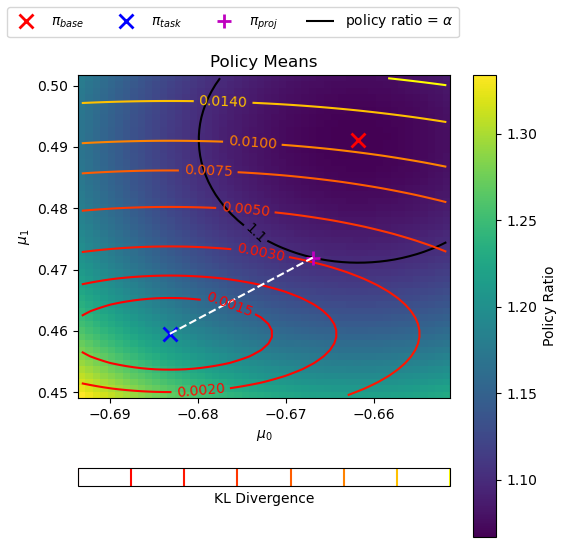

In [105]:
Nx = 50
Ny = 50

mu_x_min = min(mu_safe.value[0], mu_task.value[0], mu_proj.value[0]) - 0.01
mu_x_max = max(mu_safe.value[0], mu_task.value[0], mu_proj.value[0]) + 0.01

mu_y_min = min(mu_safe.value[1], mu_task.value[1], mu_proj.value[1]) - 0.01
mu_y_max = max(mu_safe.value[1], mu_task.value[1], mu_proj.value[1]) + 0.01

mu_x = np.linspace(mu_x_min, mu_x_max, Nx)
mu_y = np.linspace(mu_y_min, mu_y_max, Ny)

policy_ratio = np.zeros((Ny, Nx))
kl_divergence = np.zeros((Ny, Nx))
mu = np.zeros(2)

for i in range(0, Nx):
    for j in range(0, Ny):
        mu[0] = mu_x[i]
        mu[1] = mu_y[j]
        policy_ratio[j][i] = np.prod(
            np.multiply(
                sigma_safe.value / sigma_proj.value,
                np.exp(
                    1
                    / 2
                    * np.square(mu - mu_safe.value)
                    / (np.square(sigma_safe.value) - np.square(sigma_proj.value))
                ),
            )
        )
        kl_divergence[j][i] = (
            1
            / 2
            * np.sum(
                2 * np.log(sigma_task.value)
                - 2 * np.log(sigma_proj.value)
                - 1
                + np.square(sigma_proj.value) / np.square(sigma_task.value)
                + np.square(mu - mu_task.value) / np.square(sigma_task.value)
            )
        )
marker_size = 10
marker_edge_width = 2
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.pcolormesh(mu_x, mu_y, policy_ratio, linewidth=0, rasterized=True)
fig.colorbar(im, label="Policy Ratio")
cs = ax.contour(mu_x, mu_y, policy_ratio, levels=[1.1], colors="k")
h, l = cs.legend_elements()
ax.clabel(cs, inline=True, fontsize=10)
kl = ax.contour(
    mu_x,
    mu_y,
    kl_divergence,
    levels=[0.0015, 0.002, 0.003, 0.005, 0.0075, 0.01, 0.014, 0.018],
    cmap=cm.autumn,
)
ax.clabel(kl, inline=True, fontsize=10)
cbar = fig.colorbar(kl, label="KL Divergence", orientation="horizontal")
cbar.set_ticks([])
base_marker = ax.plot(
    mu_safe.value[0],
    mu_safe.value[1],
    "rx",
    markersize=marker_size,
    markeredgewidth=marker_edge_width,
)
task_marker = ax.plot(
    mu_task.value[0],
    mu_task.value[1],
    "bx",
    markersize=marker_size,
    markeredgewidth=marker_edge_width,
)
proj_marker = ax.plot(
    mu_proj.value[0],
    mu_proj.value[1],
    "m+",
    markersize=marker_size,
    markeredgewidth=marker_edge_width,
)
ax.plot(
    [mu_task.value[0], mu_proj.value[0]], [mu_task.value[1], mu_proj.value[1]], "w--"
)
ax.set_xlabel(r"$\mu_{0}$")
ax.set_ylabel(r"$\mu_{1}$")
fig.legend(
    [
        base_marker[0],
        task_marker[0],
        proj_marker[0],
        h[0],
    ],
    [
        r"$\pi_{base}$",
        r"$\pi_{task}$",
        r"$\pi_{proj}$",
        r"policy ratio = $\alpha$",
    ],
    loc="upper left",
    ncol=4,
)
ax.set_title("Policy Means")
# plt.show()
plt.savefig("policy_means.svg")

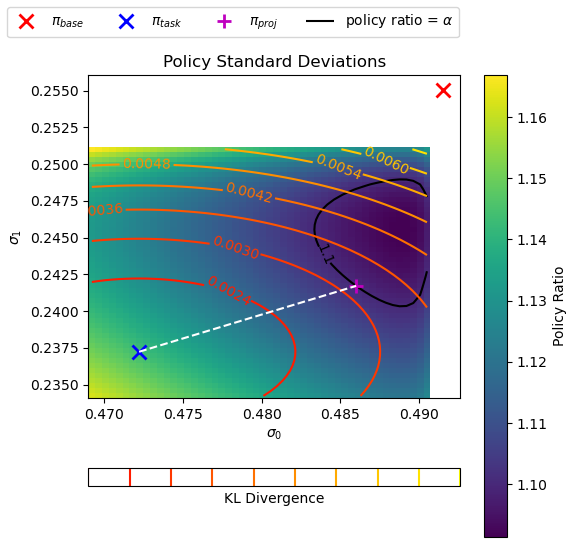

In [106]:
Nx = 50
Ny = 50
ETA_STD_X = 0.001
ETA_STD_Y = 0.004
sigma_x_min = max(
    min(sigma_safe.value[0], sigma_task.value[0], sigma_proj.value[0]) - 0.003, ETA
)
sigma_x_max = sigma_safe.value[0] - ETA_STD_X

sigma_y_min = max(
    min(sigma_safe.value[1], sigma_task.value[1], sigma_proj.value[1]) - 0.003, ETA
)
sigma_y_max = sigma_safe.value[1] - ETA_STD_Y

sigma_x = np.linspace(sigma_x_min, sigma_x_max, Nx)
sigma_y = np.linspace(sigma_y_min, sigma_y_max, Ny)

policy_ratio = np.zeros((Ny, Nx))
kl_divergence = np.zeros((Ny, Nx))
sigma = np.zeros(2)

for i in range(0, Nx):
    for j in range(0, Ny):
        sigma[0] = sigma_x[i]
        sigma[1] = sigma_y[j]
        policy_ratio[j][i] = np.prod(
            np.multiply(
                sigma_safe.value / sigma,
                np.exp(
                    1
                    / 2
                    * np.square(mu_proj.value - mu_safe.value)
                    / (np.square(sigma_safe.value) - np.square(sigma))
                ),
            )
        )
        kl_divergence[j][i] = (
            1
            / 2
            * np.sum(
                2 * np.log(sigma_task.value)
                - 2 * np.log(sigma)
                - 1
                + np.square(sigma) / np.square(sigma_task.value)
                + np.square(mu_proj.value - mu_task.value) / np.square(sigma_task.value)
            )
        )

marker_size = 10
marker_edge_width = 2
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.pcolormesh(sigma_x, sigma_y, policy_ratio, linewidth=0, rasterized=True)
fig.colorbar(im, label="Policy Ratio")
cs = ax.contour(
    sigma_x,
    sigma_y,
    policy_ratio,
    levels=[1.1],
    colors="k",
)
h, l = cs.legend_elements()
ax.clabel(cs, inline=True, fontsize=10)
kl = ax.contour(sigma_x, sigma_y, kl_divergence, levels=8, cmap=cm.autumn)
ax.clabel(kl, inline=True, fontsize=10)
cbar = fig.colorbar(kl, label="KL Divergence", orientation="horizontal")
cbar.set_ticks([])
ax.plot(
    sigma_safe.value[0],
    sigma_safe.value[1],
    "rx",
    markersize=marker_size,
    markeredgewidth=marker_edge_width,
)
ax.plot(
    sigma_task.value[0],
    sigma_task.value[1],
    "bx",
    markersize=marker_size,
    markeredgewidth=marker_edge_width,
)
ax.plot(
    sigma_proj.value[0],
    sigma_proj.value[1],
    "m+",
    markersize=marker_size,
    markeredgewidth=marker_edge_width,
)
ax.plot(
    [sigma_task.value[0], sigma_proj.value[0]],
    [sigma_task.value[1], sigma_proj.value[1]],
    "w--",
)
ax.set_xlabel(r"$\sigma_{0}$")
ax.set_ylabel(r"$\sigma_{1}$")
fig.legend(
    [
        base_marker[0],
        task_marker[0],
        proj_marker[0],
        h[0],
    ],
    [
        r"$\pi_{base}$",
        r"$\pi_{task}$",
        r"$\pi_{proj}$",
        r"policy ratio = $\alpha$",
    ],
    loc="upper left",
    ncol=4,
)
ax.set_title("Policy Standard Deviations")
# plt.show()
plt.savefig("policy_stds.svg")